In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load the data for the dynamics
Load the initial dynamics defined by the connectivity matrix $Wsoc$ and the initial condition $x_{0}$. Additionally, load the muscle activity that is going to be targeted

In [76]:
with open('initial_dynamics.npy', 'rb') as f: 
    Wsoc = np.load(f) #[N,N]
    x0 = np.load(f) #[N,1]
#Data corresponding to 5 versions of the same movement at different speeds
muscle_activity = np.load('./muscle_activity.npy')    

### Neuronal Dynamics
***
$\mathbf{\text{Euler method}}$<br>
***
&emsp;$$\tau \frac{dx}{dt} = -x + Wf\left(x, g\right)$$
&emsp;$$ \tau \frac{x(t+\Delta t) - x(t)}{\Delta t} = -x + Wf\left(x, g\right) $$
&emsp;&emsp;&emsp; $$ x(t+\Delta t) = x(t) +\frac{\Delta t}{\tau} \Bigg[-x(t) + Wf\left(x(t), g\right)\Bigg] $$
&emsp;&emsp;&emsp; $$ x_{t+1} = x_{t} +\frac{\Delta t}{\tau} \Bigg[-x_{t} + Wf\left(x_{t}, g\right)\Bigg] $$
***

### Define the parameters for the dynamics 

In [77]:
N = x0.shape[0] #Number of neurons
g0 = np.ones(x0.shape) #Vector of unitary gains [N,1]  
tf = 2500 #Final time for the dynamics
n_time =  500 #Number of time points to be considered

#Constants along the dynamics
r0, rmax = 20, 100
tau = 200

In [78]:
#Define the non - linear function
def f_nonL(x,g): #x:[N,1] g:[N,1]
    mask = x < 0
    constant = np.zeros(x.shape) #[N,1]
    constant[mask] = r0
    constant[~mask] = rmax - r0  
    
    return constant*np.tanh(x*g*(1./constant)) #[N,1]

In [79]:
def euler_solution(x0, tf, g,  n_time):
    x = np.zeros((N,n_time)) #[N,n_time]
    x[:,0] = x0.squeeze() #Set the initial dynamics 
    delta_t = tf/n_time
    #Solve the dynamics with the Euler method
    for time in range(1,n_time):
        x_past = x[:,time -1] #[N,]
        x_past = np.expand_dims(x_past, 1) #[N,1]
        F = np.matmul(Wsoc, f_nonL(x_past,g)) #[N,1]
        x_present = x_past + (delta_t/tau)*(-x_past + F) #[N,1]
    
        x[:,time] = x_present.squeeze()
    return x    

## Euler method for different $\Delta t$ values changing the number of time points 

<ipython-input-80-1283b6842b9e>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


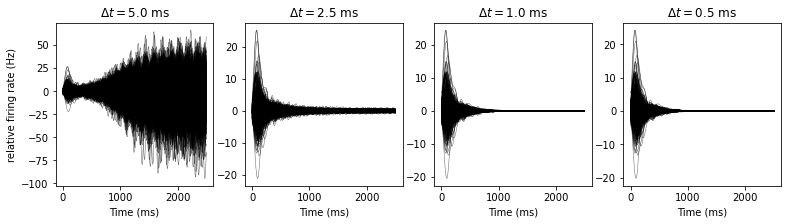

In [80]:
x1 = euler_solution(x0, tf = 2500, g = g0, n_time = 500)
x2 = euler_solution(x0, tf = 2500, g = g0, n_time = 1000)
x3 = euler_solution(x0, tf = 2500, g = g0, n_time = 2500)
x4 = euler_solution(x0, tf = 2500, g = g0, n_time = 5000)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize = (13,3), ncols = 4)
ax0.plot(np.linspace(0,2500,500), x1.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax0.set_xlabel('Time (ms)') 
ax0.set_ylabel('relative firing rate (Hz)') 
ax0.set_title('$\Delta t = $'+ str(tf/500) + ' ms' )
ax1.plot(np.linspace(0,tf,1000), x2.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax1.set_xlabel('Time (ms)') 
ax1.set_title('$\Delta t = $'+ str(tf/1000) + ' ms') 
ax2.plot(np.linspace(0,tf,2500), x3.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax2.set_xlabel('Time (ms)') 
ax2.set_title('$\Delta t = $'+ str(tf/2500) + ' ms') 
ax3.plot(np.linspace(0,tf,5000), x4.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax3.set_xlabel('Time (ms)') 
ax3.set_title('$\Delta t = $'+ str(tf/5000) + ' ms') 

fig.show()

### Let's implement now a RK-4 

***
$\mathbf{\text{Runge-Kutta method (4th order)}}$<br>
***
&emsp;$$\tau \frac{dx}{dt} = -x + Wf\left(x, g\right)$$
&emsp;$$\frac{dx}{dt} =\frac{1}{\tau}\Bigg[-x + Wf\left(x, g\right)\Bigg]$$
&emsp;$$\frac{dx}{dt} =f_{dyn}(x,t) = f_{dyn}(x)$$
&emsp;$$ x_{t+1} = x_{t} + \frac{\Delta t}{6}(k_{1}+2k_{2}+2k_{3}+k_{4})$$
&emsp;$$ k_{1} = f_{dyn}(x_{t})$$
&emsp;$$ k_{2} = f_{dyn}(x_{t}+\frac{h}{2}k_{1})$$
&emsp;$$ k_{3} = f_{dyn}(x_{t}+\frac{h}{2}k_{2})$$
&emsp;$$ k_{4} = f_{dyn}(x_{t}+hk_{3})$$
***

In [81]:
def f_dynamics(x,g):
    F_dyn = np.matmul(Wsoc, f_nonL(x,g)) #[N,1]
    return (1/tau)*(-x + F_dyn)

def RK4(x0, tf, g, n_time):
    x = np.zeros((N,n_time)) #[N,n_time]
    x[:,0] = x0.squeeze() #Set the initial condition 
    h = tf/n_time #delta time in RK4
    
    for time in range(1,n_time):
        x_past = x[:,time-1] #[N,]
        x_past = np.expand_dims(x_past, 1) #[N,1]
        
        k1 = f_dynamics(x_past, g)
        k2 = f_dynamics(x_past + (h/2)*k1, g)
        k3 = f_dynamics(x_past + (h/2)*k2, g)
        k4 = f_dynamics(x_past + h*k3, g)
        
        x_present = x_past + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    
        x[:,time] = x_present.squeeze() 
    return x  

## RK4 for different $\Delta t$ values changing the number of time points 

<ipython-input-82-be565d0171f1>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


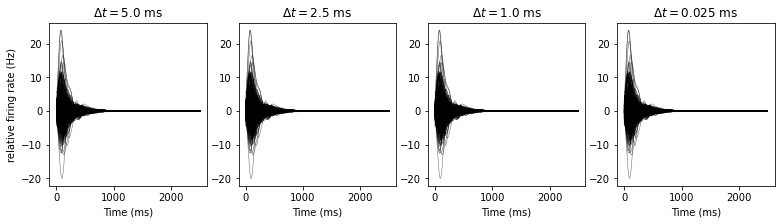

In [82]:
x_ideal = RK4(x0, tf = 2500, g= g0 , n_time = 500)
x1 = RK4(x0, tf = 2500, g= g0 , n_time = 1000)
x2 = RK4(x0, tf = 2500, g= g0 ,  n_time = 2500)
x3 = RK4(x0, tf = 2500, g= g0 , n_time = 100000)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize = (13,3), ncols = 4)
ax0.plot(np.linspace(0,2500,500), x_ideal.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax0.set_xlabel('Time (ms)') 
ax0.set_ylabel('relative firing rate (Hz)') 
ax0.set_title('$\Delta t = $'+ str(tf/500) + ' ms' )
ax1.plot(np.linspace(0,2500,1000), x1.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax1.set_xlabel('Time (ms)') 
ax1.set_title('$\Delta t = $'+ str(tf/1000) + ' ms') 
ax2.plot(np.linspace(0,tf,2500), x2.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax2.set_xlabel('Time (ms)') 
ax2.set_title('$\Delta t = $'+ str(tf/2500) + ' ms') 
ax3.plot(np.linspace(0,tf,100000), x3.T, color = 'k', linewidth = 0.5 , alpha = 0.6)
ax3.set_xlabel('Time (ms)') 
ax3.set_title('$\Delta t = $'+ str(tf/100000) + ' ms') 

fig.show()

We see then that the Euler method is not good enough when considering a time step of $\Delta t = 5\text{ms} $. On the other hand, RK4 method works perfectly good with that time step 

### Define the functions for the dynamics with a ODEINT solver 

In [85]:
from scipy.integrate import odeint

params = {
    'n_time' : n_time,
    'over_tau' : 1/200,
    'over_tau_ON' : 1/400, #For prep activity
    'over_tau_OFF' : 1/2, #For prep activity
    't_f' : 2500,
    'r0' : 20,
    'rmax' : 100,
    'gains' : g_slow
    }

def f_NL(x):
    
    x = x.reshape(N,1) #Reshape the squeezed vector 
    out = np.zeros(np.shape(x)) #Output vector
    
    r0 = params['r0']
    rmax = params['rmax']
    g = params['gains']
    
    negative = x<0 #Find the negative index for activity    
    out[negative] = r0*np.tanh(g[negative]*x[negative]/r0)
    
    positive = ~negative 
    out[positive] = (rmax-r0)*np.tanh(g[positive]*x[positive]/(rmax-r0))
    
    return np.squeeze(out)

def dynamics(x,t,W):
    
    dxdt = params['over_tau']*(-x + W.dot(f_NL(x)))# + u)
    
    return np.squeeze(dxdt)

def run_dynamics(W, current_gains, params, x_initial):
    
    params['gains'] = current_gains #Update the gains
    time = np.linspace(0,params['t_f'],params['n_time'])
    
    X = odeint(dynamics, np.squeeze(x_initial), time, args=(W,))
    R = final_f_NL(X)
    
    sol = {
        't' : time,
        'R' : R
        }
    return sol

def final_f_NL(X):
    
    G = np.tile(np.transpose(params['gains']),(params['n_time'],1))
    R = np.zeros(np.shape(X))
        
    r0 = params['r0']
    rmax = params['rmax']
        
    negative = X<0    
    R[negative] = r0*np.tanh(G[negative]*X[negative]/r0)
        
    positive = ~negative 
    R[positive] = (rmax-r0)*np.tanh(G[positive]*X[positive]/(rmax-r0))
         
    return R   

### Define the output function 
Define the output of the network i.e. how the  muscle activity is gonna be produced. In  this case, it corresponds to a weighted linear readout of the relative firing rates of the excitatory (E) neurons:
&emsp;$$z(t) = w^{T}f(x^{(E)}, g^{(E)}) + b$$


In [55]:
readout = np.concatenate(([b],w.T))

def output(R, readout):
   
    design = np.zeros((params['n_time'],200+1))
    design[:,0] = np.ones((params['n_time'],)) #Offset bias
    design[:,1:] = R[:,:200]      
    
    output = design.dot(readout)    
    return output    

### Load the data from the RNN training with back-propagation 

In [86]:
with open('trainRNN_with_relu.npy', 'rb') as f:  
    g_slow = np.load(f)
    w = np.load(f)
    b = np.load(f)
    losses = np.load(f)
    losses_slow = np.load(f)
    losses_fast = np.load(f)
    x_fast_seqs = np.load(f)
    x_slow_seqs = np.load(f)
    z_fast_seqs = np.load(f)
    z_slow_seqs = np.load(f)

### Run the dynamics for the slow and fast version of the movement using the RK, ODEINT and compare with the RNN output 

In [56]:
slow_dynamics = run_dynamics(Wsoc, g_slow.T , params, x0) 
fast_dynamics = run_dynamics(Wsoc, np.ones((N,1)) , params, x0)
z_slow = output(slow_dynamics['R'], readout)
z_fast = output(fast_dynamics['R'], readout)

params['gains'] = g_slow.T
slow_dynamics_RNN = final_f_NL(x_slow_seqs[-1,:,:])
params['gains'] = np.ones((N,1))
fast_dynamics_RNN = final_f_NL(x_fast_seqs[-1,:,:])
z_slow_RNN = output(slow_dynamics_RNN, readout)
z_fast_RNN = output(fast_dynamics_RNN, readout)

x_slow_RNN = RK4(x0, tf = 2500, g = g_slow.T , n_time = 500)
x_fast_RNN = RK4(x0, tf = 2500, g = np.ones((N,1)) , n_time = 500)
params['gains'] = g_slow.T
f_RNN_slow = final_f_NL(x_slow_RNN.T)
params['gains'] = np.ones((N,1))
f_RNN_fast = final_f_NL(x_fast_RNN.T)
z_slow_RK = output(f_RNN_slow, readout)
z_fast_RK = output(f_RNN_fast, readout)

<ipython-input-57-2ee57feb50f9>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


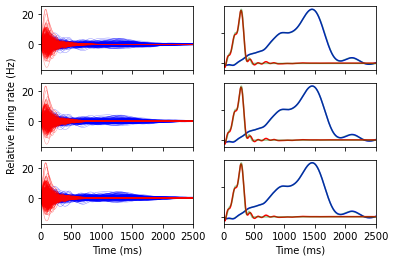

In [57]:
tf_plot = 2500
n_points = int(tf_plot*1/5)
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2)
ax0.plot(np.linspace(0,tf_plot,n_points),(slow_dynamics['R'])[:tf_plot,:], color = 'b', linewidth = 0.5, alpha = 0.4)
ax0.plot(np.linspace(0,tf_plot,n_points),(fast_dynamics['R'])[:tf_plot,:], color = 'r', linewidth = 0.5, alpha = 0.4)
ax0.set_xlim([0,tf_plot])
ax1.plot(np.linspace(0,tf_plot,n_points),z_slow[:tf_plot], color = 'b')
ax1.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,-1], color = 'green', alpha = 0.4)
ax1.plot(np.linspace(0,tf_plot,n_points),z_fast[:tf_plot], color = 'r')
ax1.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,0], color = 'green', alpha = 0.4)
ax1.set_xlim([0,tf_plot])
ax1.set_xlabel('Time (ms)')
ax2.plot(np.linspace(0,tf_plot,n_points), slow_dynamics_RNN[:tf_plot,:] , color = 'b', linewidth = 0.5, alpha = 0.4)
ax2.plot(np.linspace(0,tf_plot,n_points), fast_dynamics_RNN[:tf_plot,:] , color = 'r', linewidth = 0.5, alpha = 0.4)
ax2.set_ylabel('Relative firing rate (Hz)')
ax2.set_xlim([0,tf_plot])
ax3.plot(np.linspace(0,tf_plot,n_points),z_slow_RNN[:tf_plot], color = 'b')
ax3.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,-1], color = 'green', alpha = 0.4)
ax3.plot(np.linspace(0,tf_plot,n_points),z_fast_RNN[:tf_plot], color = 'r')
ax3.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,0], color = 'green', alpha = 0.4)
ax3.set_xlim([0,tf_plot])
ax3.set_xlabel('Time (ms)')
ax4.plot(np.linspace(0,tf_plot,n_points), f_RNN_slow[:tf_plot,:] , color = 'b', linewidth = 0.5 , alpha = 0.5)
ax4.plot(np.linspace(0,tf_plot,n_points), f_RNN_fast[:tf_plot,:] , color = 'r', linewidth = 0.5 , alpha = 0.5)
ax4.set_xlabel('Time (ms)') 
ax4.set_xlim([0,tf_plot])
ax5.plot(np.linspace(0,tf_plot,n_points),z_slow_RK[:tf_plot], color = 'b')
ax5.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,-1], color = 'green', alpha = 0.4)
ax5.plot(np.linspace(0,tf_plot,n_points),z_fast_RK[:tf_plot], color = 'r')
ax5.plot(np.linspace(0,tf_plot,n_points),muscle_activity[:tf_plot,0], color = 'green', alpha = 0.4)
ax5.set_xlim([0,tf_plot])
ax5.set_xlabel('Time (ms)')
for ax in fig.get_axes():
    ax.label_outer()
fig.show()

### Take a look on the relative firing rates and the firing rates:

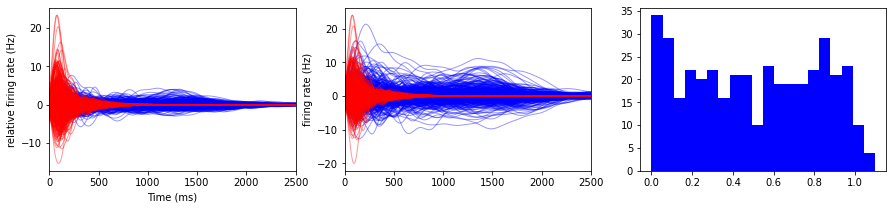

In [102]:
x_slow_RNN = RK4(x0, tf = 2500, g = g_slow.T , n_time = 500)
x_fast_RNN = RK4(x0, tf = 2500, g = np.ones((N,1)) , n_time = 500)
params['gains'] = g_slow.T
f_RNN_slow = final_f_NL(x_slow_RNN.T)
params['gains'] = np.ones((N,1))
f_RNN_fast = final_f_NL(x_fast_RNN.T)

fig, (ax0, ax1, ax2) = plt.subplots(figsize = (15,3), ncols = 3)
ax0.plot(np.linspace(0,2500,500), f_RNN_slow[:,:] , color = 'b', linewidth = 1, alpha = 0.4)
ax0.plot(np.linspace(0,2500,500), f_RNN_fast[:,:] , color = 'r', linewidth = 1, alpha = 0.4)
ax0.set_xlabel('Time (ms)')
ax0.set_xlim([0,2500])
ax0.set_ylabel('relative firing rate (Hz)')
ax1.plot(np.linspace(0,2500,500), (x_slow_RNN.T)[:,:] , color = 'b', linewidth = 1, alpha = 0.4)
ax1.plot(np.linspace(0,2500,500), (x_fast_RNN.T)[:,:] , color = 'r', linewidth = 1, alpha = 0.4)
ax1.set_xlim([0,2500])
ax1.set_ylabel('firing rate (Hz)')
ax2.hist(g_slow.T, bins = 20, color = 'b')
plt.show()

###  Let's take a look on the linear interpolation of the gains

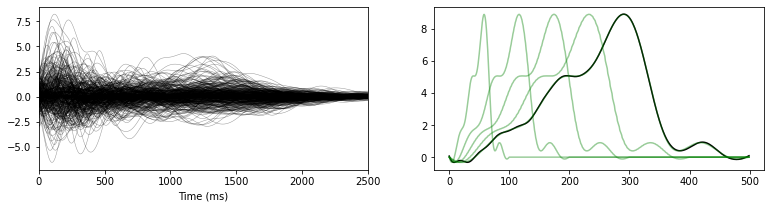

In [93]:
beta = 1
g_fast = np.ones((1,N))
g_interpolation = (1-beta)*g_fast + beta*g_slow
x_interpolation = RK4(x0, tf = 2500, g = g_interpolation.T , n_time = 500)
params['gains'] = g_interpolation.T
f_interpolation = final_f_NL(x_interpolation.T)
z_interpolation = output(f_interpolation, readout)

fig, (ax0, ax1) = plt.subplots(figsize = (13,3), ncols = 2)
ax0.plot(np.linspace(0,2500,500),f_interpolation, color = 'k', linewidth = 0.5, alpha = 0.4)
ax0.set_xlabel('Time (ms)')
ax0.set_xlim([0,2500])
ax1.plot(z_interpolation, color = 'k')
ax1.plot(muscle_activity[:,:], color = 'green', alpha = 0.4)
plt.show()

<ipython-input-103-0235895f2051>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f6.show()


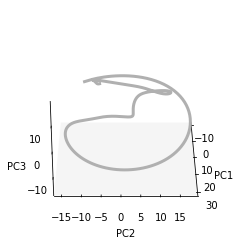

In [103]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

red_t0 , green_t0 , blue_t0  = 0.690, 0.690, 0.690
red_tf , green_tf , blue_tf  = 0.301, 0.776, 0.937

pca = PCA(n_components = 3)

Neural_activity = positive_dynamics_slow['R'] #FOR NORMAL PCA
#Neural_activity = activity_loop #FOR LOOP

x = StandardScaler().fit_transform(Neural_activity) #Standardize data

principalComponents = pca.fit_transform(x)

f6 = plt.figure(6)
ax = f6.gca(projection = '3d')

ax.plot(principalComponents[:,0],principalComponents[:,1],principalComponents[:,2], 
         color = (red_t0, green_t0, blue_t0),linewidth=3)

   
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = True

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.view_init(30, 0)
ax.grid(False)

f6.show()